# Moneyball Project: UEFA Euro 2020 Fantasy Football
Passion project to leverage data-driven decision making for team selection in [UEFA Euro 2020 Fantasy Football](https://gaming.uefa.com/en/uefaeuro2020fantasyfootball/overview)

## Modelling
-----------------------------
### Purpose
Project points and roi of player for matchday 1 of UEFA Euro 2020

### Author
[Christian Wibisono](https://github.com/christianwbsn)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from IPython.display import display

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row',50)

In [2]:
DATA_DIR = '../data'

In [3]:
data = pd.read_csv("{}/processed/dataset.csv".format(DATA_DIR))

In [4]:
train = data[~pd.isnull(data["points"])]
train["roi"] = train["roi"].fillna(0)
test = data[pd.isnull(data["points"])]
test = test.drop_duplicates(subset=["player", "date"], keep="first")
test = test.reset_index(drop=True)

<ipython-input-4-3198189a0046>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["roi"] = train["roi"].fillna(0)


In [5]:
train.shape

(7137, 114)

In [6]:
test.shape

(617, 114)

In [7]:
train.head()

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
0,Aaron Ramsey,2018-09-06 00:00:00,UEFA Nations League,Wales,Republic of Ireland,21.00,90.0,M,2018,9,6,7.0,8.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,19,1536,26,29,1484,0.0,2.0,2.0,0.0,4.0,3.0,25.6,1.767500e+09,68000000.0,25.5,7.765000e+08,29900000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,52,-10,9.910000e+08,38100000.0,0.1,True,False,1.0,0.823529,False,High,High
1,Aaron Ramsey,2018-09-09 00:00:00,UEFA Nations League,Wales,Denmark,13.50,90.0,M,2018,9,9,2.0,8.5,3.0,7.0,1.0,0.0,7.000000,1.0,0.0,7.0,NaN,NaN,NaN,90.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,1.00,18,19,1536,9,9,1580,0.0,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-44,10,-1.339500e+09,-51500000.0,-2.2,True,False,1.0,0.235294,False,High,High
2,Aaron Ramsey,2018-10-11 00:00:00,International Friendlies,Wales,Spain,1.42,90.0,M,2018,10,11,2.0,8.5,3.0,2.0,0.0,0.0,4.500000,0.5,0.0,7.0,3.535534,0.707107,0.0,90.0,1.0,2.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,1.00,18,19,1536,6,9,1597,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-61,10,NaN,NaN,NaN,False,False,1.0,0.235294,False,High,High
3,Aaron Ramsey,2018-11-16 00:00:00,UEFA Nations League,Wales,Denmark,2.96,90.0,M,2018,11,16,2.0,8.5,3.0,2.0,0.0,0.0,3.666667,0.0,0.0,7.0,2.886751,0.577350,0.0,90.0,1.0,3.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0,0.75,18,18,1538,9,10,1584,0.0,1.0,0.0,0.0,2.0,2.0,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26

In [8]:
train.columns

Index(['player', 'date', 'league_name', 'team_name', 'opponent_name',
       'fantasy_points', 'min', 'position', 'year', 'month',
       ...
       'diff_team_market_value', 'diff_team_mean_market_value',
       'diff_team_mean_squad_age', 'is_senior', 'is_imbalanced',
       'gap_to_potential', 'roi', 'more_likely_to_win', 'attacking_work_rate',
       'defending_work_rate'],
      dtype='object', length=114)

In [9]:
fifa_col = ['attacking_crossing','attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'height_cm', 'weight_kg',
            'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
            'movement_reactions', 'movement_balance', 'power_shot_power',
            'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
            'mentality_aggression', 'mentality_interceptions',
            'mentality_positioning', 'mentality_vision', 'mentality_penalties',
            'mentality_composure', 'defending_standing_tackle',
            'defending_sliding_tackle', 'goalkeeping_diving',
            'goalkeeping_handling', 'goalkeeping_kicking',
            'goalkeeping_positioning', 'goalkeeping_reflexes', 'pace', 
            'dribbling', 'physic']

In [10]:
dropped_cols = ['player', 'league_name', 'date', 'year','points',
                'roi', 'value', 'min', 'nation_position',
                'last_md_assists', 'last_md_goals', 'prev_std_assists',
                'month', 'day', 'nation_jersey_number','team_name', 'opponent_name',
                'fantasy_points', 'prev_mean_goals', 'prev_median_min', "prev_std_goals",
                "prev_team_highest_rank" , "prev_opponent_highest_rank", "is_senior", "hth_draw"]

In [11]:
dropped_cols += fifa_col

In [12]:
def train_model(df, dropped_cols, label, model, need_fillna):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    if need_fillna:
        X = X.fillna(0)
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mae, mse = mean_absolute_error(y_test, prediction), mean_squared_error(y_test, prediction)
    print(model)
    print("MAE:", mae)
    print("MSE:", mse)

Need to find sweet spot between player consistency and speculation (The Mavericks) --> player with high volatility of points [http://www.frontier-economics.com/uk/en/news-and-articles/articles/article-i7337-how-to-win-your-fantasy-football-league/] 
* roi -> measuring value for money (find undervalued player)
* points --> measuring player consistency

In [13]:
model_roi = RandomForestRegressor(random_state=1)
train_model(train, dropped_cols, "roi", model_roi, True)

RandomForestRegressor(random_state=1)
MAE: 0.2928345514973823
MSE: 0.1694851570117875


In [14]:
model_points = LGBMRegressor(random_state=1)
train_model(train, dropped_cols, "points", model_points, False)

LGBMRegressor(random_state=1)
MAE: 1.8358431764092022
MSE: 6.174204972817047


## The Dream Team

In [15]:
X_test = pd.get_dummies(test.drop(dropped_cols, axis=1))

In [16]:
def plotImp(model, X , num =20, fig_size = (9, 3)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title(str(model) +' Features')
    plt.tight_layout()
    plt.show()

In [17]:
def get_model(df, dropped_cols, label, model, need_fillna):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    if need_fillna:
        X = X.fillna(0)
    y = df[label]
    model.fit(X, y)
    print(X.columns)
    plotImp(model,X, 10)
    return model

Index(['skill', 'last_md_points', 'prev_mean_points', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_ratio_starter',
       'count_played', 'goal_consistency', 'assist_consistency',
       'clean_sheet_consistency', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'prev_ratio_played', 'team_rank',
       'team_total_points', 'opponent_rank', 'opponent_total_points',
       'hth_team_win', 'hth_opp_win', 'hth_team_score', 'hth_opp_score',
       'htt_max_margin', 'team_mean_squad_age', 'team_market_value',
       'team_mean_market_value', 'opponent_mean_squad_age',
       'opponent_market_value', 'opponent_mean_market_value', 'age',
       'league_rank', 'overall', 'potential', 'wage_eur',
       'international_reputation', 'shooting', 'passing', 'defending',
       'attacking_finishing', 'diff_team_points', 'diff_team_ranking',
       'diff_team_market_value', 'diff_team_m

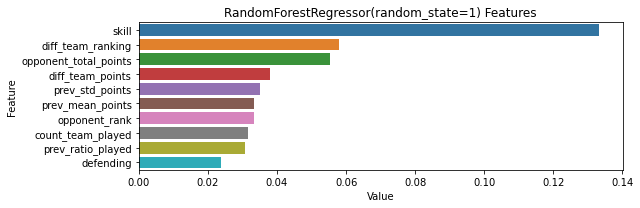

Index(['skill', 'last_md_points', 'prev_mean_points', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_ratio_starter',
       'count_played', 'goal_consistency', 'assist_consistency',
       'clean_sheet_consistency', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'prev_ratio_played', 'team_rank',
       'team_total_points', 'opponent_rank', 'opponent_total_points',
       'hth_team_win', 'hth_opp_win', 'hth_team_score', 'hth_opp_score',
       'htt_max_margin', 'team_mean_squad_age', 'team_market_value',
       'team_mean_market_value', 'opponent_mean_squad_age',
       'opponent_market_value', 'opponent_mean_market_value', 'age',
       'league_rank', 'overall', 'potential', 'wage_eur',
       'international_reputation', 'shooting', 'passing', 'defending',
       'attacking_finishing', 'diff_team_points', 'diff_team_ranking',
       'diff_team_market_value', 'diff_team_m

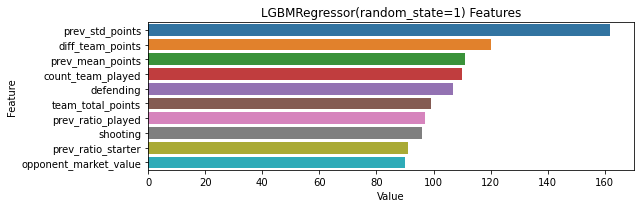

In [18]:
model_1 = get_model(train, dropped_cols, 'roi', model_roi, True)
model_2 = get_model(train, dropped_cols, 'points', model_points, False)

In [19]:
import shap
shap.initjs()

In [20]:
explainer = shap.Explainer(model_2)
shap_obj = explainer(X_test)

In [21]:
def player_to_watch(shap_obj, df, player_name):
    print("Evaluating points for: ", player_name)
    player = df[(df["player"] == player_name)][:1]
    display(player)
    shap.plots.waterfall(shap_obj[player.index[0]])

In [22]:
X_test

,skill,last_md_points,prev_mean_points,prev_mean_assists,prev_max_points,prev_std_points,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,team_rank,team_total_points,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,league_rank,overall,potential,wage_eur,international_reputation,shooting,passing,defending,attacking_finishing,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_imbalanced,gap_to_potential,more_likely_to_win,position_D,position_F,position_GK,position_M,attacking_work_rate_High,attacking_work_rate_Low,attacking_work_rate_Medium,defending_work_rate_High,defending_work_rate_Low,defending_work_rate_Medium
0,3.0,3.0,3.875000,0.000000,13.0,4.155461,0.750000,8.0,0.125000,0.0,0.250000,27.0,NaN,NaN,NaN,0.296296,17,1570,13,1606,1.0,1.0,3.0,4.0,3.0,25.6,1.767500e+09,68000000.0,27.0,2.835000e+09,109000000.0,29.0,1.0,82.0,82.0,98000.0,3.0,77.0,79.0,68.0,75.0,-36,4,-1.067500e+09,-41000000.0,-1.4,False,0.0,False,0,0,0,1,1,0,0,1,0,0
1,3.0,1.0,2.000000,0.333333,4.0,1.732051,0.000000,3.0,0.000000,0.0,0.000000,29.0,NaN,NaN,NaN,0.103448,29,1505,7,1642,0.0,0.0,0.0,0.0,NaN,25.0,3.250000e+09,125000000.0,27.8,7.640000e+09,293800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-137,22,-4.390000e+09,-168800000.0,-2.8,True,NaN,False,0,0,0,1,0,0,0,0,0,0
2,1.0,1.0,1.000000,0.000000,1.0,0.000000,0.000000,2.0,0.000000,0.0,0.000000,27.0,NaN,NaN,NaN,0.074074,17,1570,13,1606,1.0,1.0,3.0,4.0,3.0,25.6,1.767500e+09,68000000.0,27.0,2.835000e+09,109000000.0,27.0,2.0,70.0,73.0,12000.0,1.0,NaN,NaN,NaN,11.0,-36,4,-1.067500e+09,-41000000.0,-1.4,False,3.0,False,0,0,1,0,0,0,1,0,0,1
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,1458,44,1441,1.0,4.0,4.0,7.0,1.0,27.4,1.900000e+09,73100000.0,27.3,2.698500e+09,103800000.0,17.0,1.0,74.0,87.0,500.0,1.0,71.0,68.0,32.0,70.0,17,-4,-7.985000e+08,-30700000.0,0.1,False,13.0,False,0,0,0,0,1,0,0,0,0,1
4,3.0,1.0,1.200000,0.000000,2.0,0.447214,0.200000,5.0,0.000000,0.0,0.000000,27.0,NaN,NaN,NaN,0.185185,6,1648,18,1569,1.0,0.0,4.0,1.0,3.0,26.5,9.150000e+09,381300000.0,29.2,2.150500e+09,82700000.0,24.0,1.0,79.0,85.0,80000.0,1.0,66.0,68.0,38.0,66.0,79,-12,6.999500e+09,298600000.0,-2.7,True,6.0,True,0,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,3.0,1.0,2.227273,0.045455,8.0,1.688387,0.909091,22.0,0.000000,0.0,0.272727,26.0,NaN,NaN,NaN,0.846154,37,1468,5,1666,0.0,2.0,3.0,7.0,3.0,28.1,7.485000e+08,28800000.0,27.9,8.725000e+09,335600000.0,25.0,2.0,72.0,77.0,29000.0,1.0,54.0,73.0,70.0,48.0,-198,32,-7.976500e+09,-306800000.0,0.2,True,5.0,False,0,0,0,1,0,0,1,1,0,0
613,4.0,5.0,3.416667,0.083333,10.0,2.357535,0.958333,24.0,0.041667,0.0,0.291667,26.0,NaN,NaN,NaN,0.923077,37,1468,5,1666,0.0,2.0,3.0,7.0,3.0,28.1,7.485000e+08,28800000.0,27.9,8.725000e+09,335600000.0,32.0,1.0,71.0,71.0,18000.0,2.0,71.0,59.0,39.0,71.0,-198,32,-7.976500e+09,-306800000.0,0.2,True,0.0,False,0,1,0,0,0,0,1,0,0,1
614,2.0,2.0,2.000000,0.000000,2.0,NaN,1.000000,1.0,0.000000,0.0,0.000000,26.0,NaN,NaN,NaN,0.038462,37,1468,5,1666,0.0,2.0,3.0,7.0,3.0,28.1,7.485000e+08,28800000.0,27.9,8.725000e+09,335600000.0,24.0,1.0,64.0,72.0,2000.0,1.0,31.0,43.0,65.0,26.0,-198,32,-7.976500e+09,-306800000.0,0.2,True,8.0,False,1,0,0,0,0,1,0,0,0,1
615,4.0,2.0,3.312500,0.062500,10.0,2.701080,0.750000,16.0,0.062500,0.0,0.312500,27.0,1.0,5.0,5.0,0.592593,6,1648,18,1569,1.0,0.0,4.0,1.0,3.0,26.5,9.150000e+09,381300000.0,29.2,2.150500e+09,

In [23]:
test["predicted_roi"] = model_1.predict(X_test.fillna(0))
test["predicted_points"] = model_2.predict(X_test)

## Surfacing The Result

In [24]:
fantasy_euro = pd.read_csv("{}/interim/fantasy_euro.csv".format(DATA_DIR))

In [25]:
fantasy_euro = fantasy_euro[["player", "date", "league_name", "team_name", 
                             "opponent_name", "value", "skill", "sel_per"]]

In [26]:
players = pd.merge(test, 
                   fantasy_euro[["player", "sel_per"]],
                   how='left', on="player")

In [27]:
players = players.drop_duplicates(subset=["player", "team_name"])

In [28]:
players = players[~pd.isnull(players['position'])]
players = players[players['prev_ratio_starter'] > 0.75]
players = players[players['prev_ratio_played'] > 0.55]

In [29]:
scaler = StandardScaler()
players["scaled_points"] = scaler.fit_transform(players["predicted_points"].values.reshape(-1,1))
players["scaled_roi"] = scaler.fit_transform(players["predicted_roi"].values.reshape(-1,1))

In [30]:
players["final_score"] = players["scaled_points"] * 0.8 + players["scaled_roi"] * 0.2

In [31]:
players = players.sort_values(by=["final_score"], ascending=False)

In [32]:
col = ["player", "team_name", "opponent_name", "position", 'hth_team_win', 'hth_opp_win', "value", "predicted_roi", "predicted_points", "final_score", "prev_max_points", "prev_mean_points", "prev_std_points", "prev_ratio_starter", "prev_ratio_played"]

In [33]:
views = players[col]

In [34]:
views.head(20)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
512,Romelu Lukaku,Belgium,Russia,F,4.0,0.0,11.0,0.706587,5.350700,2.569725,13.0,7.375000,3.263434,1.000000,0.592593
494,Robert Lewandowski,Poland,Slovakia,F,1.0,1.0,11.5,0.547203,4.975962,1.992611,14.0,5.105263,3.710267,0.947368,0.730769
208,Hakan Calhanoglu,Turkey,Italy,M,0.0,0.0,8.5,0.687652,4.712297,1.924750,10.0,4.090909,3.084664,0.909091,0.758621
481,Raphael Guerreiro,Portugal,Hungary,D,2.0,0.0,6.5,0.953592,4.326761,1.906625,6.0,4.176471,2.007339,0.941176,0.629630
322,Kylian Mbappé,France,Germany,F,4.0,2.0,12.0,0.511916,4.933238,1.903897,12.0,3.900000,3.193744,0.800000,0.714286
482,Raphael Varane,France,Germany,D,4.0,2.0,6.0,0.812100,4.472727,1.858853,8.0,3.958333,2.440227,0.916667,0.857143
96,Cristiano Ronaldo,Portugal,Hungary,F,2.0,0.0,12.0,0.587951,4.768697,1.846002,18.0,5.736842,5.064496,0.947368,0.703704
608,Wojciech Szczesny,Poland,Slovakia,GK,1.0,1.0,5.0,0.780650,4.412036,1.757838,7.0,3.533333,2.325838,1.000000,0.576923
192,Georginio Wijnaldum,Netherlands,Ukraine,M,0.0,0.0,8.0,0.630518,4.386244,1.531794,18.0,5.280000,4.596375,1.000000,0.925926
63,Benjamin Pavard,France,Germany,D,4.0,2.0,6.0,0.571873,4.407899,1.474290,9.0,3.285714,2.629503,0.952381,0.750000


## Goalkeeper

In [35]:
views[views["position"] == "GK"]

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
608,Wojciech Szczesny,Poland,Slovakia,GK,1.0,1.0,5.0,0.780650,4.412036,1.757838,7.0,3.533333,2.325838,1.0,0.576923
196,Gianluigi Donnarumma,Italy,Turkey,GK,0.0,0.0,5.5,0.838798,3.950014,1.387264,7.0,4.894737,2.024701,1.0,0.703704
515,Rui Patrício,Portugal,Hungary,GK,2.0,0.0,5.5,0.812648,3.763720,1.171438,7.0,4.315789,2.473249,1.0,0.703704
301,Kasper Schmeichel,Denmark,Finland,GK,1.0,0.0,5.0,0.716402,3.840459,1.117056,7.0,4.375000,2.355613,1.0,0.923077
146,Dominik Livakovic,Croatia,England,GK,1.0,1.0,5.0,0.908911,3.530730,1.074190,7.0,3.277778,1.994273,1.0,0.720000
216,Hugo Lloris,France,Germany,GK,4.0,2.0,6.0,0.773610,3.656058,1.014675,7.0,4.263158,2.353298,1.0,0.678571
604,Wayne Hennessey,Wales,Switzerland,GK,1.0,1.0,5.0,0.806672,3.518991,0.925909,7.0,4.000000,2.357023,1.0,0.703704
562,Thibaut Courtois,Belgium,Russia,GK,4.0,0.0,6.0,0.833892,3.367773,0.815585,7.0,4.666667,2.169305,1.0,0.666667
504,Robin Olsen,Sweden,Spain,GK,0.0,1.0,5.0,0.787596,3.292048,0.680101,7.0,3.684211,2.262070,1.0,0.678571
612,Yann Sommer,Switzerland,Wales,GK,1.0,1.0,5.0,0.706298,3.357758,0.635027,14.0,4.095238,3.144913,1.0,0.807692


Evaluating points for:  Gianluigi Donnarumma


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
189,Gianluigi Donnarumma,2021-06-11 21:00:00,European Championship 2020,Italy,Turkey,NaN,NaN,GK,2021,6,11,NaN,5.5,1.0,6.0,0.0,0.0,4.894737,0.0,0.0,7.0,2.024701,0.0,0.0,90.0,1.0,19.0,0.0,0.0,0.631579,27.0,NaN,NaN,NaN,0.703704,7,7,1642,29,29,1505,0.0,0.0,0.0,0.0,0.0,NaN,27.8,7.640000e+09,293800000.0,25.0,3.250000e+09,125000000.0,21.0,196.0,90.0,1.0,85.0,92.0,34000.0,3.0,NaN,NaN,NaN,NaN,NaN,GK,21.0,NaN,12.0,12.0,12.0,34.0,8.0,28.0,12.0,14.0,24.0,28.0,46.0,54.0,64.0,79.0,38.0,57.0,72.0,34.0,72.0,18.0,30.0,26.0,14.0,50.0,24.0,68.0,14.0,16.0,89.0,81.0,76.0,83.0,89.0,137,-22,4.390000e+09,168800000.0,2.8,False,True,7.0,NaN,False,Medium,Medium,0.838798,3.950014


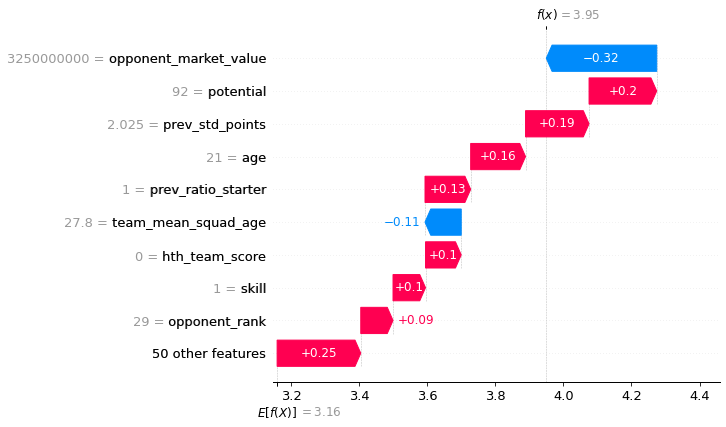

In [36]:
player_to_watch(shap_obj, test, "Gianluigi Donnarumma")

Evaluating points for:  Wojciech Szczesny


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
597,Wojciech Szczesny,2021-06-14 18:00:00,European Championship 2020,Poland,Slovakia,NaN,NaN,GK,2021,6,14,NaN,5.0,1.0,1.0,0.0,0.0,3.533333,0.0,0.0,7.0,2.325838,0.0,0.0,90.0,1.0,15.0,0.0,0.0,0.4,26.0,NaN,NaN,NaN,0.576923,6,21,1549,24,36,1475,1.0,1.0,0.0,1.0,2.0,2.0,27.1,2.768000e+09,106500000.0,28.2,1.311000e+09,50400000.0,30.0,195.0,90.0,1.0,87.0,87.0,105000.0,3.0,NaN,NaN,NaN,NaN,NaN,GK,1.0,NaN,12.0,12.0,16.0,32.0,14.0,11.0,16.0,14.0,36.0,22.0,51.0,47.0,55.0,82.0,51.0,55.0,71.0,45.0,65.0,14.0,40.0,15.0,14.0,48.0,18.0,65.0,13.0,12.0,86.0,82.0,73.0,87.0,88.0,74,-15,1.457000e+09,56100000.0,-1.1,True,True,0.0,NaN,False,Medium,Medium,0.78065,4.412036


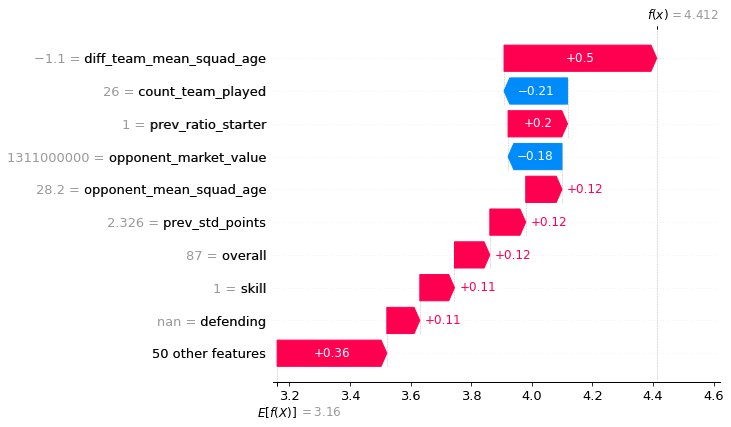

In [37]:
player_to_watch(shap_obj, test, "Wojciech Szczesny")

## Defender

In [38]:
views[(views["position"] == "D")].head(20)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
481,Raphael Guerreiro,Portugal,Hungary,D,2.0,0.0,6.5,0.953592,4.326761,1.906625,6.0,4.176471,2.007339,0.941176,0.629630
482,Raphael Varane,France,Germany,D,4.0,2.0,6.0,0.812100,4.472727,1.858853,8.0,3.958333,2.440227,0.916667,0.857143
63,Benjamin Pavard,France,Germany,D,4.0,2.0,6.0,0.571873,4.407899,1.474290,9.0,3.285714,2.629503,0.952381,0.750000
292,Kamil Glik,Poland,Slovakia,D,1.0,1.0,5.5,0.544298,4.057068,1.096862,12.0,4.000000,3.023716,0.954545,0.846154
521,Rúben Dias,Portugal,Hungary,D,2.0,0.0,6.0,0.752505,3.669500,0.999465,13.0,3.730769,3.000769,0.961538,0.962963
541,Stefan Lainer,Austria,North Macedonia,D,2.0,0.0,5.0,0.898836,3.397897,0.931775,11.0,4.000000,2.756810,0.952381,0.777778
27,Andreas Christensen,Denmark,Finland,D,1.0,0.0,5.5,0.653345,3.704758,0.900920,6.0,3.150000,2.400734,0.800000,0.769231
402,Mehmet Zeki Çelik,Turkey,Italy,D,0.0,0.0,4.5,0.546843,3.796400,0.847271,18.0,3.611111,4.272193,0.944444,0.620690
273,João Cancelo,Portugal,Hungary,D,2.0,0.0,6.0,0.737152,3.435101,0.751406,9.0,3.736842,2.725234,0.842105,0.703704
536,Simon Kjaer,Denmark,Finland,D,1.0,0.0,4.5,0.620495,3.505094,0.663147,9.0,4.043478,2.513206,0.826087,0.884615


Evaluating points for:  Martin Hinteregger


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
379,Martin Hinteregger,2021-06-13 18:00:00,European Championship 2020,Austria,North Macedonia,NaN,NaN,D,2021,6,13,NaN,4.5,2.0,2.0,0.0,0.0,3.136364,0.0,0.045455,9.0,2.782521,0.213201,0.213201,90.0,1.0,22.0,0.0,0.0,0.318182,27.0,0.0,2.0,2.0,0.814815,22,23,1523,62,62,1374,2.0,0.0,0.0,6.0,2.0,3.0,27.9,3.206000e+09,123300000.0,27.6,618000000.0,23800000.0,27.0,186.0,82.0,1.0,80.0,82.0,33000.0,2.0,71.0,70.0,65.0,60.0,81.0,LCB,4.0,82.0,53.0,65.0,84.0,67.0,64.0,54.0,58.0,63.0,81.0,65.0,65.0,75.0,64.0,76.0,63.0,83.0,86.0,76.0,84.0,71.0,82.0,77.0,67.0,65.0,61.0,74.0,84.0,83.0,14.0,14.0,9.0,13.0,10.0,149,-39,2.588000e+09,99500000.0,0.3,False,True,2.0,NaN,True,High,Medium,0.803247,3.206133


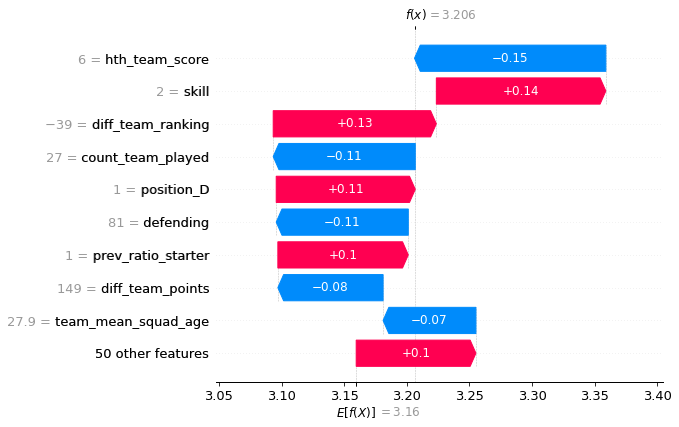

In [39]:
player_to_watch(shap_obj, test, "Martin Hinteregger")

Evaluating points for:  Stefan Lainer


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
531,Stefan Lainer,2021-06-13 18:00:00,European Championship 2020,Austria,North Macedonia,NaN,NaN,D,2021,6,13,NaN,5.0,2.0,0.0,0.0,0.0,4.0,0.0,0.190476,11.0,2.75681,0.218218,0.402374,90.0,0.952381,21.0,0.0,0.0,0.380952,27.0,1.0,11.0,6.5,0.777778,22,23,1523,62,62,1374,2.0,0.0,0.0,6.0,2.0,3.0,27.9,3.206000e+09,123300000.0,27.6,618000000.0,23800000.0,27.0,175.0,70.0,1.0,80.0,80.0,41000.0,1.0,80.0,63.0,70.0,75.0,73.0,RB,21.0,80.0,78.0,59.0,64.0,76.0,63.0,76.0,65.0,33.0,70.0,71.0,82.0,78.0,77.0,77.0,78.0,73.0,68.0,93.0,72.0,65.0,88.0,74.0,66.0,60.0,45.0,75.0,74.0,77.0,10.0,14.0,7.0,8.0,7.0,149,-39,2.588000e+09,99500000.0,0.3,False,True,0.0,NaN,True,High,High,0.898836,3.397897


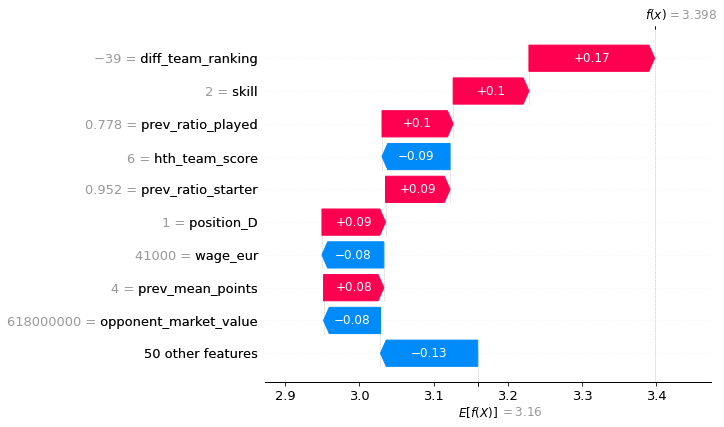

In [40]:
player_to_watch(shap_obj, test, "Stefan Lainer")

## Midfielder

In [41]:
views[(views["position"] == "M")].head(20)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
208,Hakan Calhanoglu,Turkey,Italy,M,0.0,0.0,8.5,0.687652,4.712297,1.924750,10.0,4.090909,3.084664,0.909091,0.758621
192,Georginio Wijnaldum,Netherlands,Ukraine,M,0.0,0.0,8.0,0.630518,4.386244,1.531794,18.0,5.280000,4.596375,1.000000,0.925926
563,Thomas Delaney,Denmark,Finland,M,1.0,0.0,5.5,0.682422,4.111087,1.334226,9.0,2.904762,1.972429,1.000000,0.807692
115,David Alaba,Austria,North Macedonia,M,2.0,0.0,5.5,0.658030,4.095298,1.286242,8.0,3.062500,1.982213,1.000000,0.592593
84,Christian Eriksen,Denmark,Finland,M,1.0,0.0,9.0,0.575750,4.127043,1.206888,16.0,5.333333,4.439611,0.916667,0.923077
64,Bernardo Silva,Portugal,Hungary,M,2.0,0.0,8.5,0.518398,3.989974,0.997064,11.0,4.240000,2.989983,0.880000,0.925926
70,Bruno Fernandes,Portugal,Hungary,M,2.0,0.0,10.5,0.418290,3.874040,0.750505,8.0,2.631579,2.060489,0.789474,0.703704
330,Leroy Sané,Germany,France,M,2.0,4.0,9.5,0.511048,3.669093,0.675782,11.0,4.312500,3.300884,0.875000,0.592593
470,Piotr Zielinski,Poland,Slovakia,M,1.0,1.0,7.0,0.542155,3.589099,0.639790,7.0,2.818182,1.500361,0.954545,0.846154
569,Thorgan Hazard,Belgium,Russia,M,4.0,0.0,8.0,0.481228,3.660375,0.627394,12.0,3.850000,2.870448,0.850000,0.740741


Evaluating points for:  Hakan Calhanoglu


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
201,Hakan Calhanoglu,2021-06-11 21:00:00,European Championship 2020,Turkey,Italy,NaN,NaN,M,2021,6,11,NaN,8.5,3.0,10.0,1.0,1.0,4.090909,0.0,0.272727,10.0,3.084664,0.428932,0.455842,88.0,0.909091,22.0,0.0,0.0,0.318182,29.0,NaN,NaN,NaN,0.758621,29,29,1505,7,7,1642,0.0,0.0,0.0,0.0,0.0,NaN,25.0,3.250000e+09,125000000.0,27.8,7.640000e+09,293800000.0,26.0,178.0,76.0,1.0,79.0,79.0,48000.0,3.0,65.0,75.0,82.0,84.0,59.0,CAM,10.0,57.0,81.0,65.0,53.0,83.0,77.0,85.0,92.0,86.0,80.0,86.0,69.0,62.0,76.0,78.0,77.0,86.0,45.0,71.0,51.0,88.0,57.0,61.0,75.0,80.0,71.0,78.0,56.0,56.0,9.0,14.0,11.0,6.0,10.0,-137,22,-4.390000e+09,-168800000.0,-2.8,True,True,0.0,NaN,False,Medium,Medium,0.687652,4.712297


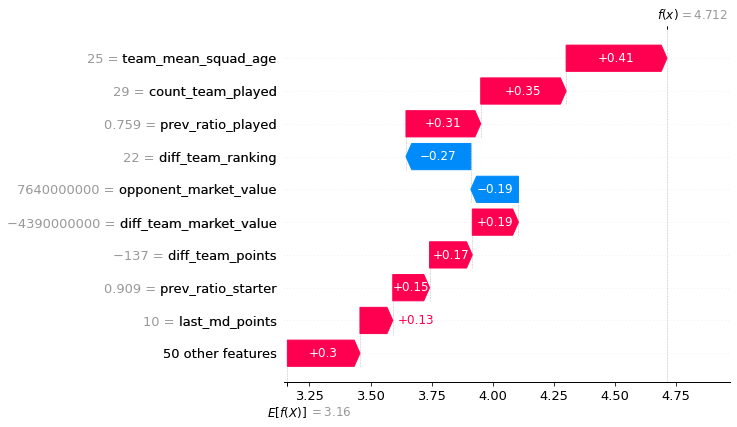

In [42]:
player_to_watch(shap_obj, test, "Hakan Calhanoglu")

Evaluating points for:  Georginio Wijnaldum


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
185,Georginio Wijnaldum,2021-06-13 21:00:00,European Championship 2020,Netherlands,Ukraine,NaN,NaN,M,2021,6,13,NaN,8.0,3.0,11.0,1.0,1.0,5.28,0.0,0.12,18.0,4.596375,0.820569,0.331662,90.0,1.0,25.0,0.12,0.0,0.36,27.0,NaN,NaN,NaN,0.925926,12,16,1598,22,24,1514,0.0,0.0,1.0,1.0,1.0,0.0,27.2,6.370500e+09,245000000.0,26.4,1.972000e+09,75800000.0,29.0,175.0,69.0,1.0,85.0,85.0,150000.0,3.0,76.0,75.0,81.0,86.0,78.0,CAM,8.0,79.0,72.0,75.0,78.0,88.0,73.0,85.0,78.0,73.0,81.0,88.0,77.0,76.0,84.0,86.0,88.0,78.0,81.0,93.0,74.0,73.0,75.0,79.0,79.0,79.0,74.0,86.0,79.0,69.0,16.0,6.0,14.0,12.0,6.0,84,-8,4.398500e+09,169200000.0,0.8,True,False,0.0,NaN,False,High,High,0.630518,4.386244


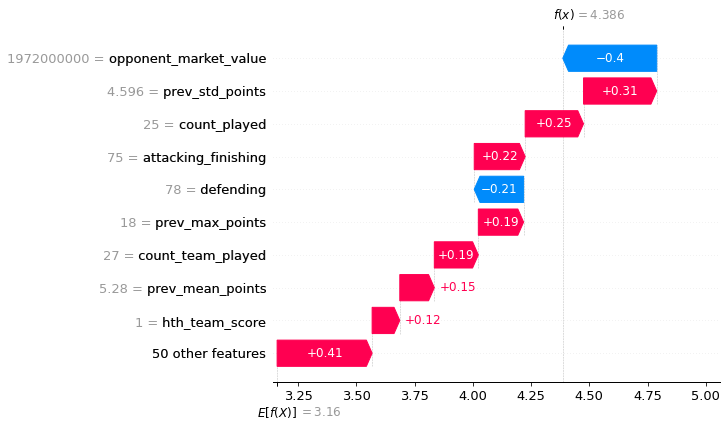

In [43]:
player_to_watch(shap_obj, test, "Georginio Wijnaldum")

## Forward

In [44]:
views[views["position"] == "F"].head(20)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
512,Romelu Lukaku,Belgium,Russia,F,4.0,0.0,11.0,0.706587,5.350700,2.569725,13.0,7.375000,3.263434,1.000000,0.592593
494,Robert Lewandowski,Poland,Slovakia,F,1.0,1.0,11.5,0.547203,4.975962,1.992611,14.0,5.105263,3.710267,0.947368,0.730769
322,Kylian Mbappé,France,Germany,F,4.0,2.0,12.0,0.511916,4.933238,1.903897,12.0,3.900000,3.193744,0.800000,0.714286
96,Cristiano Ronaldo,Portugal,Hungary,F,2.0,0.0,12.0,0.587951,4.768697,1.846002,18.0,5.736842,5.064496,0.947368,0.703704
43,Antoine Griezmann,France,Germany,F,4.0,2.0,11.0,0.519442,4.408007,1.404196,10.0,4.071429,3.078342,0.928571,1.000000
189,Gareth Bale,Wales,Switzerland,F,1.0,1.0,9.5,0.477409,4.340783,1.282671,9.0,3.350000,2.455391,0.850000,0.740741
403,Memphis Depay,Netherlands,Ukraine,F,0.0,0.0,10.0,0.445289,4.212802,1.115450,16.0,5.666667,3.829708,1.000000,0.888889
442,Olivier Giroud,France,Germany,F,4.0,2.0,8.0,0.633836,3.672483,0.843473,10.0,3.653846,2.726790,0.769231,0.928571
212,Harry Kane,England,Croatia,F,1.0,1.0,11.5,0.482825,3.690523,0.658793,17.0,5.478261,4.541421,0.869565,0.851852
381,Marko Arnautovic,Austria,North Macedonia,F,2.0,0.0,7.0,0.595494,3.516758,0.640993,10.0,4.533333,3.020564,0.866667,0.555556


Evaluating points for:  Romelu Lukaku


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
502,Romelu Lukaku,2021-06-12 21:00:00,European Championship 2020,Belgium,Russia,NaN,NaN,F,2021,6,12,NaN,11.0,4.0,6.0,1.0,0.0,7.375,1.0,0.25,13.0,3.263434,0.75,0.447214,90.0,1.0,16.0,0.375,0.0,0.4375,27.0,1.0,9.0,9.0,0.592593,1,1,1783,32,38,1462,4.0,0.0,1.0,13.0,5.0,3.0,29.2,6.694000e+09,257500000.0,27.9,1.908000e+09,73400000.0,27.0,191.0,94.0,1.0,85.0,86.0,165000.0,3.0,81.0,83.0,76.0,75.0,38.0,ST,9.0,84.0,73.0,86.0,85.0,79.0,77.0,78.0,78.0,66.0,71.0,78.0,77.0,84.0,60.0,86.0,46.0,87.0,71.0,73.0,95.0,74.0,71.0,27.0,86.0,78.0,78.0,83.0,41.0,30.0,8.0,15.0,14.0,7.0,10.0,321,-37,4.786000e+09,184100000.0,1.3,False,True,1.0,NaN,True,Medium,Medium,0.706587,5.3507


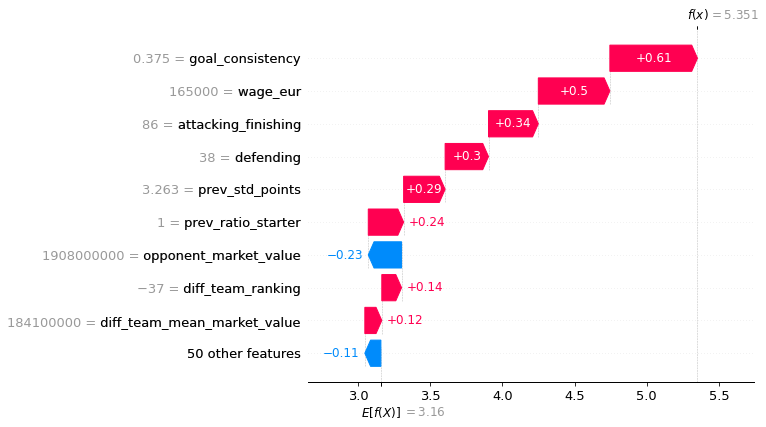

In [45]:
player_to_watch(shap_obj, test, "Romelu Lukaku")

Evaluating points for:  Marko Arnautovic


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
374,Marko Arnautovic,2021-06-13 18:00:00,European Championship 2020,Austria,North Macedonia,NaN,NaN,F,2021,6,13,NaN,7.0,4.0,5.0,0.0,1.0,4.533333,0.0,0.333333,10.0,3.020564,0.833809,0.48795,90.0,0.866667,15.0,0.2,0.0,0.4,27.0,2.0,10.0,6.0,0.555556,22,23,1523,62,62,1374,2.0,0.0,0.0,6.0,2.0,3.0,27.9,3.206000e+09,123300000.0,27.6,618000000.0,23800000.0,31.0,192.0,83.0,1.0,82.0,82.0,24000.0,3.0,80.0,82.0,79.0,79.0,44.0,ST,7.0,81.0,78.0,81.0,79.0,82.0,79.0,78.0,79.0,72.0,74.0,83.0,77.0,82.0,72.0,78.0,80.0,85.0,76.0,76.0,85.0,82.0,77.0,38.0,79.0,81.0,79.0,82.0,42.0,39.0,14.0,15.0,10.0,10.0,15.0,149,-39,2.588000e+09,99500000.0,0.3,True,True,0.0,NaN,True,Medium,Low,0.595494,3.516758


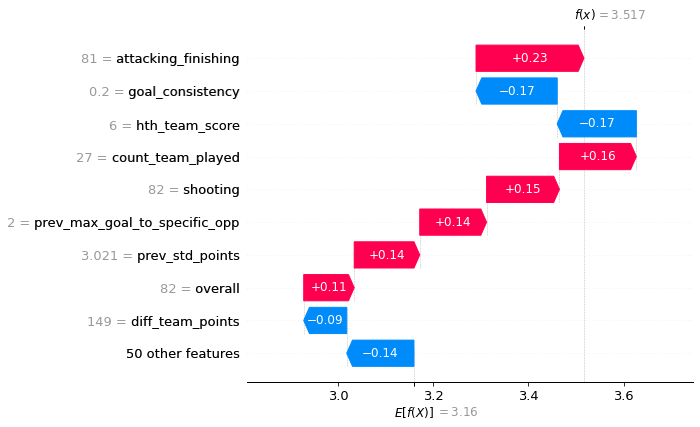

In [47]:
player_to_watch(shap_obj, test, "Marko Arnautovic")